We will use *pandas*, *numpy*, *statsmodel*, and *scipy* to hold our data and do various calculations.

In [1]:
import pandas
import numpy
import scipy.stats
from statsmodels.formula.api import ols

*requests_cache* lets us download Shiller's data from the web and cache the data locally so we're not downloading it **every** time we run this.
*xlrd* is an Excel engine that lets pandas parse the Excel file and build a DataFrame from it.

In [2]:
import requests_cache
import xlrd

We will use *matplotlib* to graph a few things.
Configure it to use a different default style.
*seaborn-poster* generates bigger (and more legible) charts.

In [17]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-poster')

Other assorted modules we use.

In [18]:
import datetime

We use *requests_cache* to download Shiller's excel file from his website and cache it for three days.

We do a bit of data munging on the spreadsheet -- renaming columns and deleting a few unused columns.

In [31]:
def get_shiller(url="http://www.econ.yale.edu/~shiller/data/ie_data.xls"):
    expire_after = datetime.timedelta(days=3)
    session = requests_cache.CachedSession(cache_name='data-cache', backend='sqlite', expire_after=expire_after)

    excel = session.get(url, stream=True)
    # must be wrapped in a BytesIO for read_excel to accept it...
    df = pandas.read_excel(pandas.io.common.BytesIO(excel.content),
                           sheet_name='Data',
                           engine='xlrd',
                           skiprows=7,
                           skipfooter=11, # WARN: is this always 11?
                           index_col=0,
                           parse_dates=True)
    df.rename(columns={'P' : 'Price',
                      'D' : 'Dividend',
                      'E' : 'Earnings',
                      'Price' : 'Real Price',
                      'Dividend' : 'Real Dividend',
                      'Price.1' : 'Real Total Return Price',
                      'Earnings' : 'Real Earnings',
                      'Earnings.1' : 'Real Total Return Scaled Earnings'}, inplace=True)
    del(df['Unnamed: 13'], df['Unnamed: 15']) # garbage columns from Shiller's spreadsheet
    return df

shiller = get_shiller()
shiller.head()

,Price,Dividend,Earnings,CPI,Fraction,Rate GS10,Real Price,Real Dividend,Real Total Return Price,Real Earnings,Real Total Return Scaled Earnings,CAPE,TR CAPE
Date,,,,,,,,,,,,,
1871-01-01,4.44,0.26,0.4,12.464061,1871.041667,5.320000,91.599130,5.363913,91.599130,8.252174,8.252174,NaN,NaN
1871-02-01,4.50,0.26,0.4,12.844641,1871.125000,5.323333,90.086245,5.204983,90.519993,8.007666,8.046222,NaN,NaN
1871-03-01,4.61,0.26,0.4,13.034972,1871.208333,5.326667,90.940801,5.128982,91.808138,7.890742,7.965999,NaN,NaN
1871-04-01,4.74,0.26,0.4,12.559226,1871.291667,5.330000,97.047287,5.323269,98.420700,8.189645,8.305544,NaN,NaN
1871-05-01,4.86,0.26,0.4,12.273812,1871.375000,5.333333,101.818048,5.447056,103.719322,8.380086,8.536570,NaN,NaN


Now we can generate some derived columns.
* Dividend yield (which use to calculate total return)
* month over month price increase
* month over month total return (which is just the price increase plus dividend yield)
* the month over month change in CPI (Shiller only provides absolute numbers)
* the real (inflation-adjusted) month over month total return
* and the average CAPE *up to a given month*. This is, only based on the months preceding the current one.

In [32]:
shiller['Div Yield'] = shiller['Dividend'] / shiller['Price'] / 12
shiller['MoM Price'] = shiller['Price'] / shiller['Price'].shift(1)
shiller['MoM TR'] = shiller['MoM Price'] + shiller['Div Yield']
shiller['CPI Change'] = shiller['CPI'] / shiller['CPI'].shift(1)
shiller['Real MoM TR'] = shiller['MoM TR'] / shiller['CPI Change'] - 1
shiller['Mean CAPE'] = shiller['CAPE'].expanding().mean()
shiller.head()

,Price,Dividend,Earnings,CPI,Fraction,Rate GS10,Real Price,Real Dividend,Real Total Return Price,Real Earnings,Real Total Return Scaled Earnings,CAPE,TR CAPE,Div Yield,MoM Price,MoM TR,CPI Change,Real MoM TR,Mean CAPE
Date,,,,,,,,,,,,,,,,,,,
1871-01-01,4.44,0.26,0.4,12.464061,1871.041667,5.320000,91.599130,5.363913,91.599130,8.252174,8.252174,NaN,NaN,0.004880,NaN,NaN,NaN,NaN,NaN
1871-02-01,4.50,0.26,0.4,12.844641,1871.125000,5.323333,90.086245,5.204983,90.519993,8.007666,8.046222,NaN,NaN,0.004815,1.013514,1.018328,1.030534,-0.011844,NaN
1871-03-01,4.61,0.26,0.4,13.034972,1871.208333,5.326667,90.940801,5.128982,91.808138,7.890742,7.965999,NaN,NaN,0.004700,1.024444,1.029144,1.014818,0.014117,NaN
1871-04-01,4.74,0.26,0.4,12.559226,1871.291667,5.330000,97.047287,5.323269,98.420700,8.189645,8.305544,NaN,NaN,0.004571,1.028200,1.032771,0.963502,0.071892,NaN
1871-05-01,4.86,0.26,0.4,12.273812,1871.375000,5.333333,101.818048,5.447056,103.719322,8.380086,8.536570,NaN,NaN,0.004458,1.025316,1.029775,0.977274,0.053721,NaN


We also want to be able to calculate the actual realized real returns from a given point in time.
That is, what is the actual forward 1-year (or 3- or 5- or 10-year) return from a given month.

In [20]:
def calc_returns(df, years):
    months = years * 12
    rolling_df = df['Real MoM TR'].rolling(months)
    r = rolling_df.apply(lambda x: numpy.power(numpy.prod(x + 1), 1/years), raw=True) - 1
    df['Returns'] = r.shift(-years * 12)
    return df

In [21]:
model = ols("Returns ~ CAPE", calc_returns(shiller, 10)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     680.2
Date:                Fri, 10 Jan 2020   Prob (F-statistic):          1.94e-124
Time:                        09:13:44   Log-Likelihood:                 2660.8
No. Observations:                1538   AIC:                            -5318.
Df Residuals:                    1536   BIC:                            -5307.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1354      0.003     46.346      0.000       0.130       0.141
CAPE          -0.0043      0.000    -26.080      0.000      -0.005      -0.004
==============================================================================
Omnibus:                       33.570   Durbin-Watson:                   0.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.018
Skew:                          -0.314   Prob(JB):                     1.12e-07
Kurtosis:                       2.676   Cond. No.                         47.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
for i in range(1, 51):
    model = ols("Returns ~ CAPE", calc_returns(shiller, i)).fit()
    print(i, model.rsquared)

1 0.04358143660025726
2 0.08700768378691359
3 0.1222197322855596
4 0.14874927802170468
5 0.1746419258737142
6 0.18301628799351488
7 0.19524839842643882
8 0.22959653446896355
9 0.27363472835246583
10 0.3069149728344345
11 0.34154787111617824
12 0.3714440711556177
13 0.3881423907011775
14 0.3909585152201128
15 0.39594776673750065
16 0.39926526524690475
17 0.4017470145197064
18 0.412338809228771
19 0.4347073281948216
20 0.45389828340870075
21 0.46799803742187107
22 0.4631478542567208
23 0.43572497637324314
24 0.3920028260030849
25 0.3549098915039751
26 0.3246195938825064
27 0.27912497720221574
28 0.2517779220103771
29 0.2573340384930741
30 0.244174267270877
31 0.24350985629050337
32 0.250641881916829
33 0.2744459475061275
34 0.2774641320290079
35 0.28170963216946865
36 0.31304044611365034
37 0.34666944255149945
38 0.3844923868931335
39 0.42779898155541785
40 0.4928546624572825
41 0.5557766181729513
42 0.5964329359501347
43 0.6398026798165946
44 0.6733734532577775
45 0.7350638222550101
46 

In [23]:
ten_year = calc_returns(shiller, 10)
nanfree = ten_year.dropna()
numpy.polyfit(nanfree['CAPE'], nanfree['Returns'], 1)

array([-0.00432292,  0.13539751])

In [24]:
def guess(intercept, slope, cape):
    return intercept + (slope * cape)

/Users/justus/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


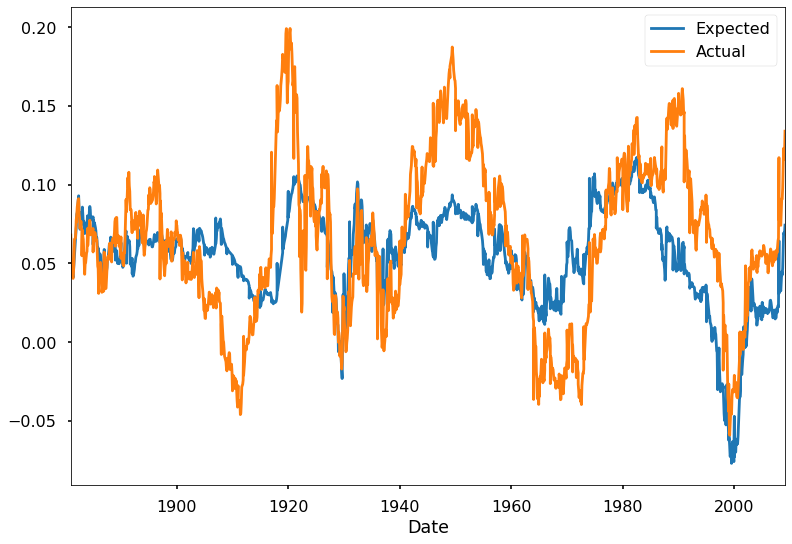

In [25]:
data=[]
for i in range(1, len(nanfree)):
    chunk = nanfree[:i]
    slope, intercept = numpy.polyfit(chunk['CAPE'], chunk['Returns'], 1)
    current = nanfree.iloc[i]
    prediction = guess(intercept, slope, current['CAPE'])
    data.append((current.name.date(), current['CAPE'], prediction, current['Returns']))
df_p = pandas.DataFrame.from_records(data, columns=['Date', 'CAPE', 'Expected', 'Actual'], index='Date')
#df_p.head()
df_p[["Expected", "Actual"]].plot()

/Users/justus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


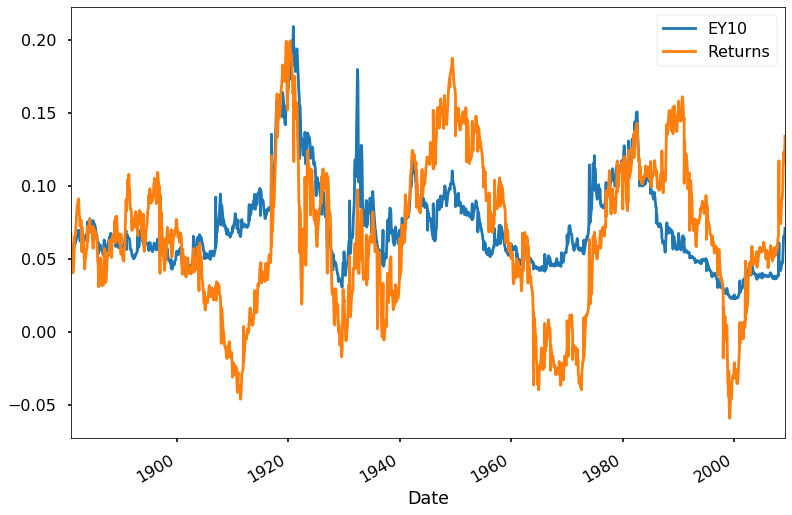

In [26]:
nanfree['EY10'] = 1 / nanfree['CAPE']
nanfree[['EY10', 'Returns']].plot()

In [27]:
model = ols("Returns ~ EY10", nanfree['1985':]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     591.0
Date:                Fri, 10 Jan 2020   Prob (F-statistic):           9.38e-72
Time:                        09:13:56   Log-Likelihood:                 612.25
No. Observations:                 290   AIC:                            -1221.
Df Residuals:                     288   BIC:                            -1213.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0496      0.005     -9.660      0.000      -0.060      -0.040
EY10           2.4878      0.102     24.311      0.000       2.286       2.689
==============================================================================
Omnibus:                       28.753   Durbin-Watson:                   0.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.333
Skew:                          -0.787   Prob(JB):                     3.50e-08
Kurtosis:                       3.601   Cond. No.                         59.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
post_1985 = nanfree['1985':][["EY10", "Returns"]]
time = 10 * 12
post_1985['EY10_delta'] = post_1985['EY10'] - post_1985['EY10'].shift(time)
post_1985['Returns_delta'] = post_1985['Returns'] - post_1985['Returns'].shift(time)
post_1985 = post_1985.dropna()
post_1985['EY10_delta'] = post_1985['EY10_delta'] < 0
post_1985['Returns_delta'] = post_1985['Returns_delta'] < 0
post_1985['SameDirection'] = ~(post_1985['EY10_delta'] ^ post_1985['Returns_delta'])
post_1985

,EY10,Returns,EY10_delta,Returns_delta,SameDirection
Date,,,,,
1995-01-01,0.049458,0.089516,True,True,True
1995-02-01,0.048071,0.087067,True,True,True
1995-03-01,0.047275,0.083570,True,True,True
1995-04-01,0.046205,0.077160,True,True,True
1995-05-01,0.045054,0.075373,True,True,True
...,...,...,...,...,...
2008-01-01,0.061023,0.117178,False,False,True
2008-11-01,0.065532,0.123095,False,False,True
2008-12-01,0.065036,0.116288,False,False,True


In [15]:
len(post_1985[post_1985['SameDirection'] == True]) / len(post_1985)

0.9588235294117647